In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# 1. Convolutions & FFT

## 1.2 Linear filter
$$x \circ f[k] = \sum x [k+i]f[i]$$

### 1.2.1 Python example: linear filters using scipy

In [2]:
linear_kernel = [1,-1,0]
signal = np.array([2,3,1,1,4])
print('Original signal:{}'.format(signal), "\n")
for filter_method in ['full', 'same', 'valid']:
    result = np.convolve(signal, linear_kernel, mode=filter_method)
    print(str(filter_method)+": {}".format(result))

Original signal:[2 3 1 1 4] 

full: [ 2  1 -2  0  3 -4  0]
same: [ 1 -2  0  3 -4]
valid: [-2  0  3]


### 1.2.2 Python example: Circulant image gradient

In [3]:
def circulant(x):
    circ = list([])
    for i in range(len(x)):
        circ.append(x[i]-x[(i-1)])
    print(circ)
circulant(signal)

[-2, 1, -2, 0, 3]


### 1.2.3 Python example: linear filters with matrices

In [4]:
x= np.random.randint(10, size=(3,3))

kernel_h = [[1,-1,0]] 
kernel_v = [[1],[-1],[0]]
print("Original matrix: \n{}".format(x))
print("Horizontal gradient: \n{}".format(convolve2d(x,kernel_h, mode='same', boundary='wrap')))
print("Vertical gradient: \n{}".format(convolve2d(x,kernel_v, mode='same', boundary='wrap')))

Original matrix: 
[[7 4 2]
 [8 1 5]
 [8 2 0]]
Horizontal gradient: 
[[-3 -2  5]
 [-7  4  3]
 [-6 -2  8]]
Vertical gradient: 
[[ 1 -3  3]
 [ 0  1 -5]
 [-1  2  2]]


# 2. Discrete gradient 2D

## 2.1 Total variation (TV)
$$TV(X) = |\nabla x|= \sum|x_{i+1}-x_i|$$

- All pairwise coordinate differences

Computation:
1. Convolve with stencil [0,1,-1]
- Take absolute value
- Take sum

## 2.2 Total variation-2d
- Total variation measures how many edges there are in your image

$$(\nabla x)_ij = (x_{i+1,j}-x_{i,j}, x_{i,j+1}-x_{i,j})$$

Anisotropic $|(\nabla x)_ij| = |x_{i+1,j}-x_{i,j}|+ |x_{i,j+1}-x_{i,j}|$

Isotropic $||(\nabla x)_ij|| = \sqrt{(x_{i+1,j}-x_{i,j})^2+ (x_{i,j+1}-x_{i,j})^2}$
- 1-L is not isotropic
- 2-L is isotropic- you can rotate and it won't change

In [5]:
np.random.seed(0)
x = np.random.randint(10, size=(3,3)) #3x3 matrix
x

array([[5, 0, 3],
       [3, 7, 9],
       [3, 5, 2]])

In [6]:
def anisotropic(x):
    x_diff = abs(x - np.roll(x, -1, axis=1))
    y_diff = abs(x - np.roll(x, -1, axis=0))
    return np.sum(x_diff+y_diff)
print("Non rotated solu: {}".format(anisotropic(x)))
for rotation in ['rot90', 'fliplr','flipud']:
    rotate = eval("np."+rotation+"(x)")
    solu = anisotropic(rotate)
    print(solu)

Non rotated solu: 60
60
60
60


In [7]:
def isotropic(x):
    x_diff = (x - np.roll(x, -1, axis=1))**2
    y_diff = (x - np.roll(x, -1, axis=0))**2
    isotropic = np.sum(np.sqrt(x_diff+y_diff))
    return isotropic
print("Non rotated solu: {}".format(np.round(isotropic(x),3)))
for rotation in ['rot90', 'fliplr','flipud']:
    rotate = eval("np."+rotation+"(x)")
    solu = np.round(isotropic(rotate),3)
    print(solu)

Non rotated solu: 45.447
46.675
46.675
46.366


# 3. Computing Total variation on images

## 3.1 Python example: Computing TV on images
### 3.1.1. Color images are represented with three matrixs: Row, Height, Color

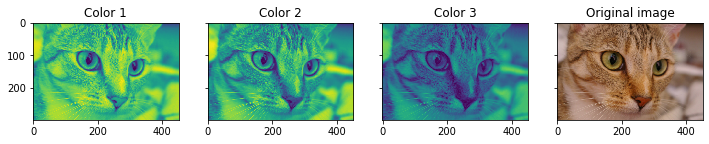

In [8]:
from skimage import data, color, img_as_float
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 6),sharex=True, sharey=True)
for i in range(0,3):
    ax[i].imshow(data.chelsea()[:,:,i])
    ax[i].set_title('Color '+str(i+1))
ax[3].imshow(data.chelsea()[:,:,:])
ax[3].set_title('Original image');

### 3.1.2.1 Isotropic TV

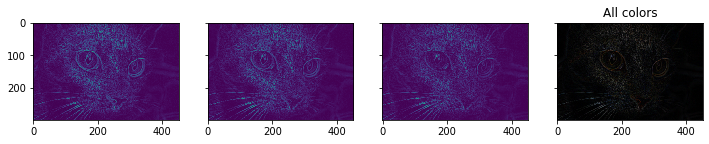

In [9]:
photo = img_as_float(data.chelsea())
def isotropic_im(x):
    x_diff = (x - np.roll(x, -1, axis=1))**2
    y_diff = (x - np.roll(x, -1, axis=0))**2
    isotropic = np.sqrt(x_diff+y_diff)
    return isotropic
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 6),sharex=True, sharey=True)
for i in range(0,3):
    ax[i].imshow((isotropic_im(photo[:,:,i])))
ax[3].imshow(isotropic_im(photo[:,:,:]))
ax[3].set_title('All colors');

### 3.1.2.2 Total variation

In [10]:
def tv_norm(x):
    """Computes the total variation norm and its gradient. From jcjohnson/cnn-vis."""
    x_diff = x - np.roll(x, -1, axis=1)
    y_diff = x - np.roll(x, -1, axis=0)
    grad_norm2 = x_diff**2 + y_diff**2
    norm = np.sum(np.sqrt(grad_norm2))
    dgrad_norm = 0.5 / np.sqrt(grad_norm2)
    dx_diff = 2 * x_diff * dgrad_norm
    dy_diff = 2 * y_diff * dgrad_norm
    grad = dx_diff + dy_diff
    grad[:, 1:, :] -= dx_diff[:, :-1, :]
    grad[1:, :, :] -= dy_diff[:-1, :, :]
    return norm, grad

/Users/corybaird/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/corybaird/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
/Users/corybaird/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


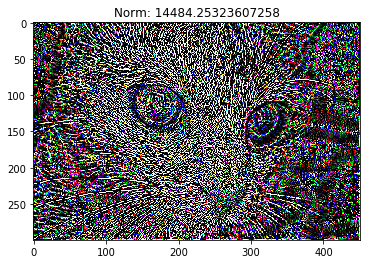

In [11]:
norm, grad = tv_norm(photo)
plt.imshow(grad)
plt.title("Norm: {}".format(str(norm)));

### 3.1.3 Linear filters and convoluations


Linear filters:
   - x-stencil = (-1,1,0)
   - y-stencil = (-1,1,0)
   
Linear convolutions:
   - x-kernel = (0,1,-1)
   - y-kernel = (0,1,-1)
   
- Take stencil lay down on image and compute inner product you are using a linear filter
- Convolving flip horizontally and vertically then lay down stencil on image.
    - Convolution net is actually a linear filter

#### 3.1.3.1 Image gradients using linear filter and convlutions

#### 3.1.3.1.1 Linear filter

In [12]:
#Linear filter
kernel_h = [[1,-1,0]] 
kernel_v = [[1],[-1],[0]]
def gradh(x):
    """Discrete gradient/difference in horizontal direction"""
    return convolve2d(x,kernel_h, mode='same', boundary='wrap')
def gradv(x):
    """Discrete gradient/difference in vertical direction"""
    return convolve2d(x,kernel_v, mode='same', boundary='wrap')

#### 3.1.3.1.2 FFT 

FFT diagnonalizes convolution matrices


$$K_x = F^T DF_x$$

Where:
- $D=$ diagonal matrix
- $F^T ,F=$ orthogonal matrices

D calculation:
- FFT of backward filter stencil

Condition number of FFT
- Poorly conditioned


In [13]:
#FFT convolution
from numpy.fft import fft2, ifft2
def gradh_fft(x):
    """Discrete gradient/difference in horizontal direction"""
    #convolve with the FLIPPED stencil to get the linear filtering we want 
    fft_kernel_h = np.zeros(x.shape) 
    fft_kernel_h[0,0] = -1
    fft_kernel_h[0,-1] = 1
    #Diagonal matrix
    Fk = fft2(fft_kernel_h)
    # Use the eigen-decomposition to convolve the stencil with X, and get the differences in the horizontal direction.
    Fx = fft2(x)
    return ifft2(Fx*Fk)
def gradv_fft(x):
    """Discrete gradient/difference in vertical direction"""
    #convolve with the FLIPPED stencil to get the linear filtering we want 
    fft_kernel_v = np.zeros(x.shape) 
    fft_kernel_v[0,0] = -1
    fft_kernel_v[-1,0] = 1
    #Diagonal matrix
    Fk = fft2(fft_kernel_v) 
    # Use the eigen-decomposition to convolve the stencil with X, and get the differences in the horizontal direction.
    Fx = fft2(x) 
    return ifft2(Fx*Fk)

#### 3.1.3.2 Plot Kernal and FFT convolutions

Are horizontal FFT and gradient equal? True
Are vertical FFT and gradient equal? True


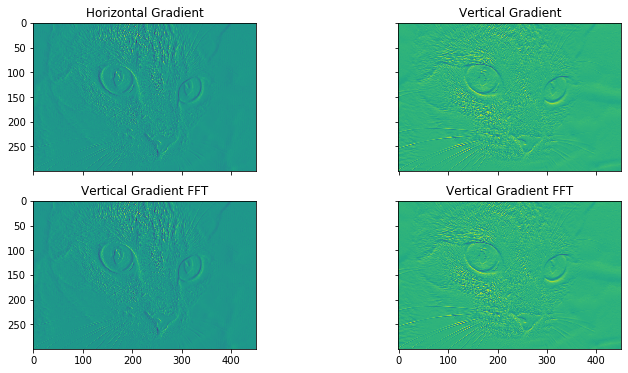

In [14]:
color1 = photo[:,:,0]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6),sharex=True, sharey=True)
ax[0,0].imshow(gradh(color1))
ax[0,0].set_title('Horizontal Gradient')
ax[0,1].imshow(gradv(color1))
ax[0,1].set_title('Vertical Gradient')
ax[1,0].imshow(np.real(gradh_fft(color1)))
ax[1,0].set_title('Vertical Gradient FFT')
ax[1,1].imshow(np.real(gradv_fft(color1)))
ax[1,1].set_title('Vertical Gradient FFT');
print("Are horizontal FFT and gradient equal? {}".format((np.round(np.real(gradh_fft(color1)),4) == np.round(gradh(color1),4)).all(1)[0]))
print("Are vertical FFT and gradient equal? {}".format((np.round(np.real(gradv_fft(color1)),4) == np.round(gradv(color1),4)).all(1)[0]))

### 3.1.4 Compute the divergence

#### 3.1.4.1 Divergence function

In [15]:
# Do not modify ANYTHING in this cell. 
def gradh(x):
    """Discrete gradient/difference in horizontal direction"""
    return convolve2d(x,kernel_h, mode='same', boundary='wrap')
def gradv(x):
    """Discrete gradient/difference in vertical direction"""
    return convolve2d(x,kernel_v, mode='same', boundary='wrap')
def grad2d(x):
    """The full gradient operator: compute both x and y differences and return them all.  The x and y 
    differences are stacked so that rval[0] is a 2D array of x differences, and rval[1] is the y differences."""
    return np.stack([gradh(x),gradv(x)])

In [16]:
def div2d(G):
    # Computing the x-differences
    #  extract the x- and y- derivatives
    Gx = G[:,:,0]
    Gy = G[:,:,1]
# We must convolve with the FLIPPED stencil to get the linear filtering we want 
    kernel = np.zeros(Gx.shape)
    kernel[0,0]=1
    kernel[0][-1] =-1
#  create diagonal matrix in decomposition K=F'DF
    Dx = np.fft.fft2(kernel)
#  Use the eigen-decomposition to convolve the stencil with X, and get the differences in the horizontal direction.
    Divx = np.fft.ifft2(Dx*np.fft.fft2(Gx))
    kernel = np.zeros(Gy.shape)
    kernel[0,0]=1
    kernel[-1][0]=-1
    
    Dy = np.fft.fft2(kernel)

    Divy = np.fft.ifft2(Dy*np.fft.fft2(Gy))
        
    return Divx+Divy
ax = grad2d(color1)
ay = div2d(ax)

#### 3.1.4.2 Plot divergence

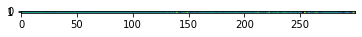

In [17]:
plt.imshow(ay.real)

## 3.2 Total variation denoising

Blurry
$$\lambda ||\nabla x||^2 +||x-f||^2$$

Crispier
$$\lambda |\nabla x| + \frac{1}{2}||x-f||^2$$

- 2-L is a bad prior for edges
    - This is because it penalizes outliers
        - $dark \rightarrow light$ has outliers
        

### 3.2.1 Python example: TV denoising
Denoising a picture Sci-kit image [Link](https://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise.html)

In [18]:
import matplotlib.pyplot as plt

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise


Estimated Gaussian noise standard deviation = 0.1510038462668498


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


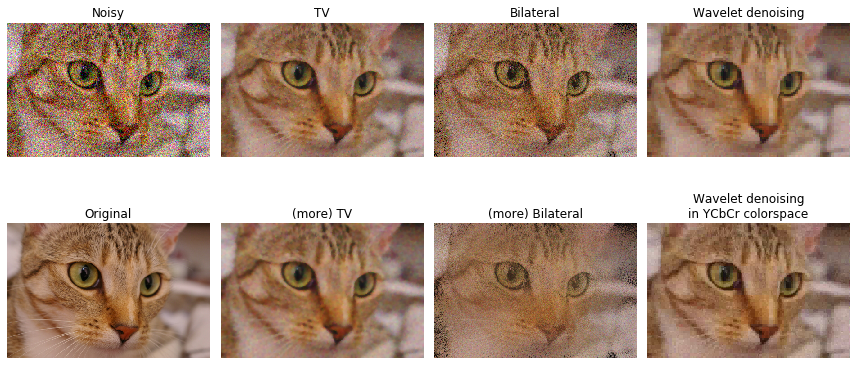

In [19]:
original = img_as_float(data.chelsea())
sigma = 0.155
noisy = random_noise(original, var=sigma**2)
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6),
                       sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, multichannel=True, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f"Estimated Gaussian noise standard deviation = {sigma_est}")

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('Noisy')
ax[0, 1].imshow(denoise_tv_chambolle(noisy, weight=0.1, multichannel=True))
ax[0, 1].axis('off')
ax[0, 1].set_title('TV')
ax[0, 2].imshow(denoise_bilateral(noisy, sigma_color=0.05, sigma_spatial=15,
                multichannel=True))
ax[0, 2].axis('off')
ax[0, 2].set_title('Bilateral')
ax[0, 3].imshow(denoise_wavelet(noisy, multichannel=True, rescale_sigma=True))
ax[0, 3].axis('off')
ax[0, 3].set_title('Wavelet denoising')

ax[1, 1].imshow(denoise_tv_chambolle(noisy, weight=0.2, multichannel=True))
ax[1, 1].axis('off')
ax[1, 1].set_title('(more) TV')
ax[1, 2].imshow(denoise_bilateral(noisy, sigma_color=0.1, sigma_spatial=15,
                multichannel=True))
ax[1, 2].axis('off')
ax[1, 2].set_title('(more) Bilateral')
ax[1, 3].imshow(denoise_wavelet(noisy, multichannel=True, convert2ycbcr=True,
                                rescale_sigma=True))
ax[1, 3].axis('off')
ax[1, 3].set_title('Wavelet denoising\nin YCbCr colorspace')
ax[1, 0].imshow(original)
ax[1, 0].axis('off')
ax[1, 0].set_title('Original')

fig.tight_layout()

plt.show()

# Fourier Transform

$$\hat{x}_k e ^{-i 2\pi k n/n}\\
\hat{x}_k = \langle x, F_k\rangle$$

- The k-th entry in the Fourier transform, take signal x, inner product of kth row in fourier
    - This is complex
    
---    
## Problem 3:  Fourier matrix
The discrete Fourier transform of a signal is a linear operator that can be performed very quickly using the fast Fourier transform (FFT).  Because it's a linear operator, we can represent the discrete Fourier transform as a matrix. 
An $N\times N$ Fourier matrix has entries
   $$F_N[r,c] = \frac{\omega^{rc}}{\sqrt{N}}, \text{ for } 0\le r,c \le N-1.$$
where $\omega_{N} = \exp\left(\frac{-2\pi i}{N}\right)$ is the Nth root of unity.  This number has the property that $\omega_N^0 = \omega_N^N = 1,$ and $|\omega_N|=1.$  A Fourier matrix is Hermitian symmetric ($F_N^H=F_N$), orthogonal ($F^H_NF_N=I_N$), and looks kinda like this...

The simplest version of the fast Fourier transform computes the DFT quickly using the Cooley-Tukey factorization
 $$F_N x = \frac{1}{\sqrt{2}}\left(\begin{array}{cc} I & D \\ I & -D \end{array}\right)  \left(\begin{array}{c}  F_{N/2}x_e \\   F_{N/2}x_o \end{array}\right)
$$
 where $D_{kk} = exp(-2\pi i k/N)$ is a diagonal matrix of "twiddle factors," $x_e=(x_0,x_2,x_4,\cdots)$ contains even-indexed components of $x$, and $x_o$ contains the odd-indexed components.  If $N$ is a power of 2, then this reduction formula enables us to compute the product $F_N x$ in $O(N\log N)$ time, which is MUCH faster than the naive matrix multiplication algorithm, which is $O(N^2).$ 
 
---
    
## Properities of FFT

Classical FFT is orthogonal
$$F^HF=I$$

Computable in O(N logN) time (Cooley-Tukey)

$$Fx = \begin{pmatrix}I & B \\ I &-B\end{pmatrix}\begin{pmatrix}Fx_{\text{even}} \\ Fx_{\text{odd}}\end{pmatrix}$$

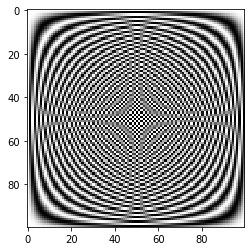

In [20]:
import numpy as np
from matplotlib import pyplot as plt
F = np.fft.fft(np.eye(100))  # Create a matrix representation by invoking the FFT on the identity.
plt.imshow(np.real(F));

## Convolution Theorem

Convolution = muliplication in Fourier domain

$$x * y = F^T (F_X \dot F_y)$$

## FFT
FFT diagnonalizes convolution matrices


$$K_x = F^T DF_x$$

Where:
- $D=$ diagonal matrix
- $F^T ,F=$ orthogonal matrices

### D calculation:
- FFT of backward filter stencil

### Condition number of FFT
- Poorly conditioned


## Image processing

## 2.2 Convolutional nets

Similar to MLP but the linear operator is different

MLP multiplies by matrix W but convolutional net multiplies it by a kernal (which can also be represented by a matrix)

Formulas are the same

We don't represent convolution as a matrix because it is expensive so we use a kernal

MLP:
$$y_1 =\sigma(x_i W_1) $$
Convnet:
$$y_1 =\sigma(x_i K_1) = \sigma(x_i \dot k_1)$$

Where:
$K_1$ = convolutional matrix
$k_1$ = stencil

$$\nabla_{z1}\ell = \nabla_{z3} \ell K_3^T \sigma\prime_2 K_2^T \sigma_1\prime$$
